In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

import cartopy.crs as ccrs
import cartopy.feature as cf

In [11]:
import graphufs
from graphufs.spatialmap import get_extend
plt.style.use("graphufs.plotstyle")

In [167]:
date = "2019-01-01T00"
plevels = [50, 100, 150, 200, 300, 400, 500]

In [188]:
# %%time
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token":"anon"},
).rename({
    "pfull": "level",
    "grid_xt": "longitude",
    "grid_yt": "latitude",
})

rds = rds[["tmp", "spfh"]]
rds = rds.sel(
    time=date,
).sel(
    level=[100, 110, 120, 130, 135,
    method="nearest"
)
rds = rds.load()

In [155]:
from datetime import datetime
def cftime2time(cf_time):
    """Convert cf_time array to numpy.datetime64

    Args:
        cf_time (xarray.DataArray): with DatetimeJulian objects

    Returns:
        xtime (xarray.DataArray): with numpy.datetime64 objects
    """
    time = np.array(
        [
            np.datetime64(
                datetime(
                    int(t.dt.year),
                    int(t.dt.month),
                    int(t.dt.day),
                    int(t.dt.hour),
                    int(t.dt.minute),
                    int(t.dt.second),
                )
            )
            for t in cf_time
        ]
    )
    xtime = xr.DataArray(
        time,
        coords=cf_time.coords,
        dims=cf_time.dims,
        attrs={
            "long_name": "time",
            "axis": "T",
        },
    )
    return xtime

In [165]:
fds = xr.open_dataset(
    "replay-data/sfg_2019010100_fhr09_control",
).rename({
    "time": "cf_time",
    "pfull": "level",
    "grid_xt": "longitude",
    "grid_yt": "latitude",
})

fds = fds[["tmp", "spfh"]]
fds = fds.sel(
    level=plevels,
    method="nearest"
)
fds["time"] = cftime2time(fds["cf_time"])
fds = fds.swap_dims({"cf_time": "time"})
fds = fds.squeeze()
fds = fds.load();

/tmp/ipykernel_2893835/1089326503.py:26: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xtime = xr.DataArray(


In [166]:
fds = fds.squeeze()

In [164]:
%%time
era = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr",
    storage_options={"token":"anon"},
)

era = era[["temperature", "specific_humidity"]]
era = era.sel(
    time=[date],
).sel(
    level=plevels,
    method="nearest"
)
era = era.load()

CPU times: user 927 ms, sys: 301 ms, total: 1.23 s
Wall time: 2.33 s


In [12]:
from graphufs.spatialmap import SpatialMap

In [13]:
mapper = SpatialMap()

In [24]:
era

<xarray.Dataset> Size: 58MB
Dimensions:            (time: 1, level: 7, latitude: 721, longitude: 1440)
Coordinates:
  * latitude           (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * level              (level) int64 56B 50 50 100 200 300 400 500
  * longitude          (longitude) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * time               (time) datetime64[ns] 8B 2019-01-01
Data variables:
    temperature        (time, level, latitude, longitude) float32 29MB 218.9 ...
    specific_humidity  (time, level, latitude, longitude) float32 29MB 3.151e...

In [130]:
figdir = "figures/replay-vs-era5"
if not os.path.isdir(figdir):
    os.makedirs(figdir)

In [169]:
vmin = {
    50: -75,
    100: -80,
    150: -80,
    200: -65,
}

In [170]:
vmax = {
    50: -40,
    100: -40,
    150: -40,
    200: -45,
}

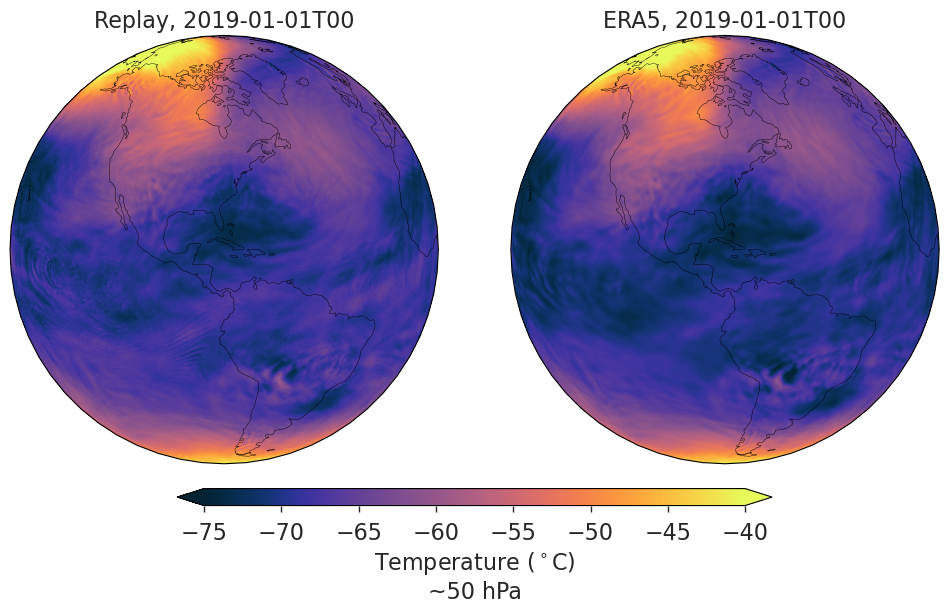

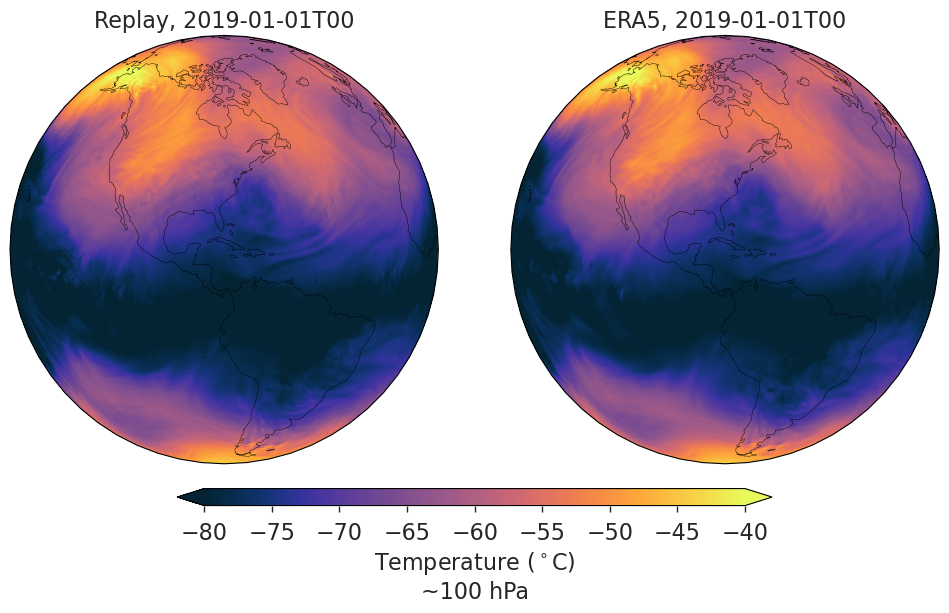

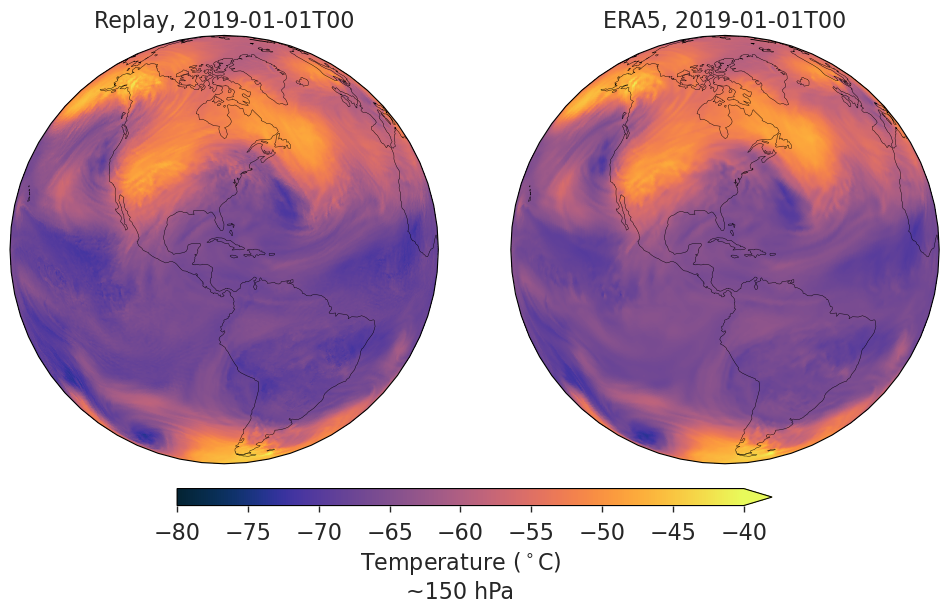

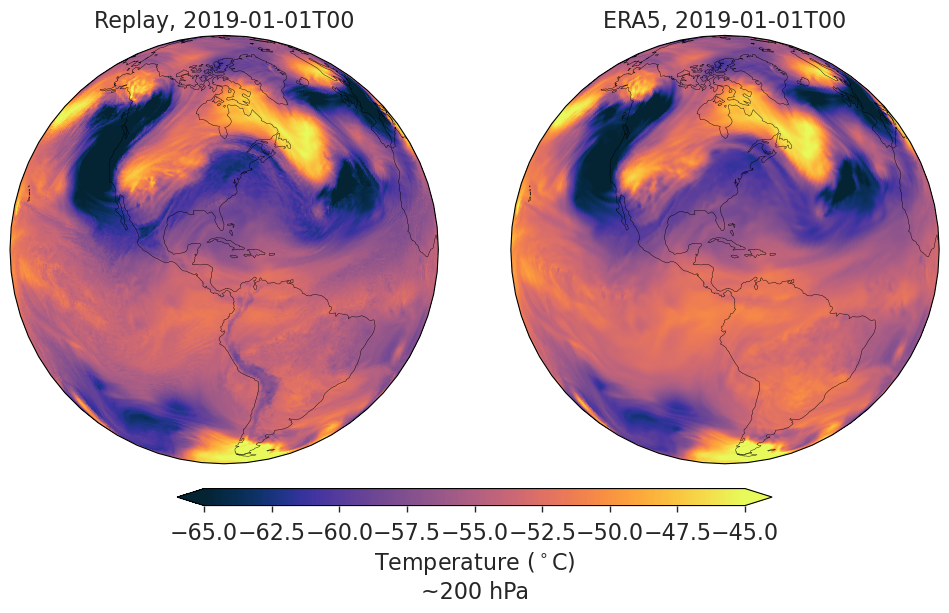

In [171]:
for level in [50, 100, 150, 200]:
    with xr.set_options(keep_attrs=True):
        fig, axs = mapper.plot(
            rds["tmp"].sel(level=level, method="nearest") - 273.15,
            era["temperature"].sel(level=level) - 273.15,
            cmap="cmo.thermal",
            vmin=vmin[level],
            vmax=vmax[level],
        )
        axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay"))
        fig.get_children()[-1].set_xlabel(f"Temperature ($^\circ$C)\n~{level} hPa")
        #fig.savefig(f"{figdir}/tmp_{level}hpa.jpeg", bbox_inches="tight", dpi=300)

In [174]:
vmin = {
    50: 2e-6,
    100: 1e-6,
    150: 1e-6,
    200: 1e-6,
}

In [183]:
vmax = {
    50: 3e-6,
    100: 4e-6,
    150: 1.5e-5,
    200: 1e-4,
}

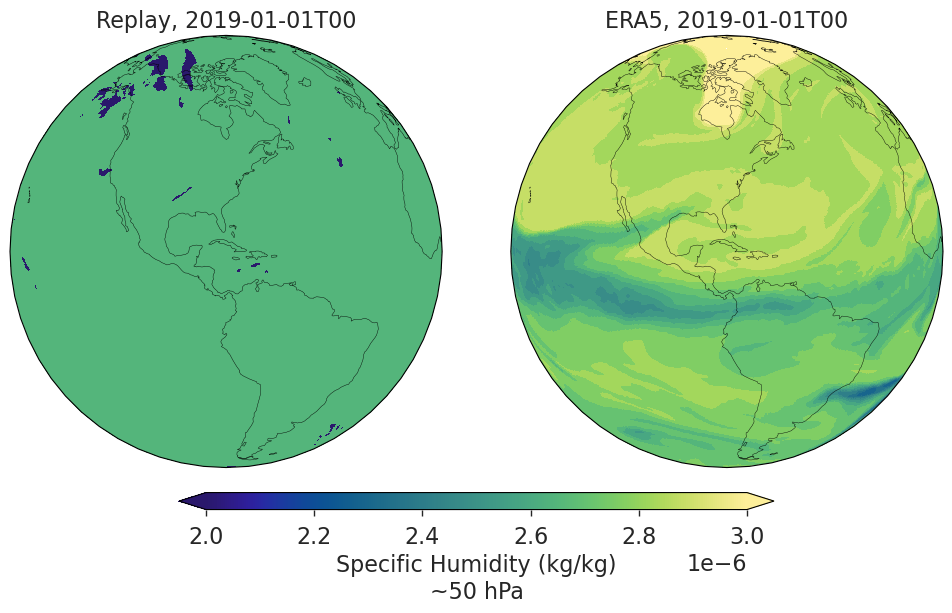

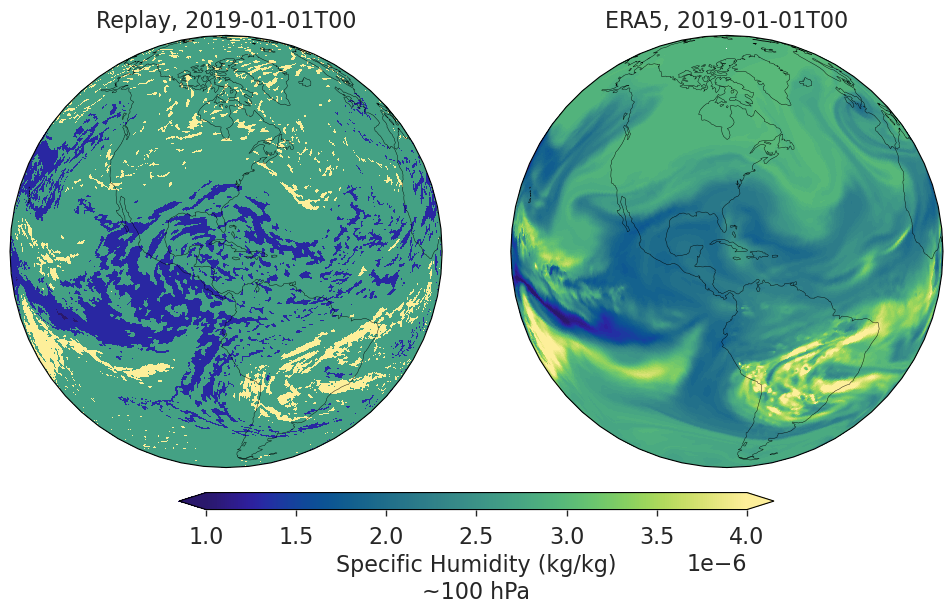

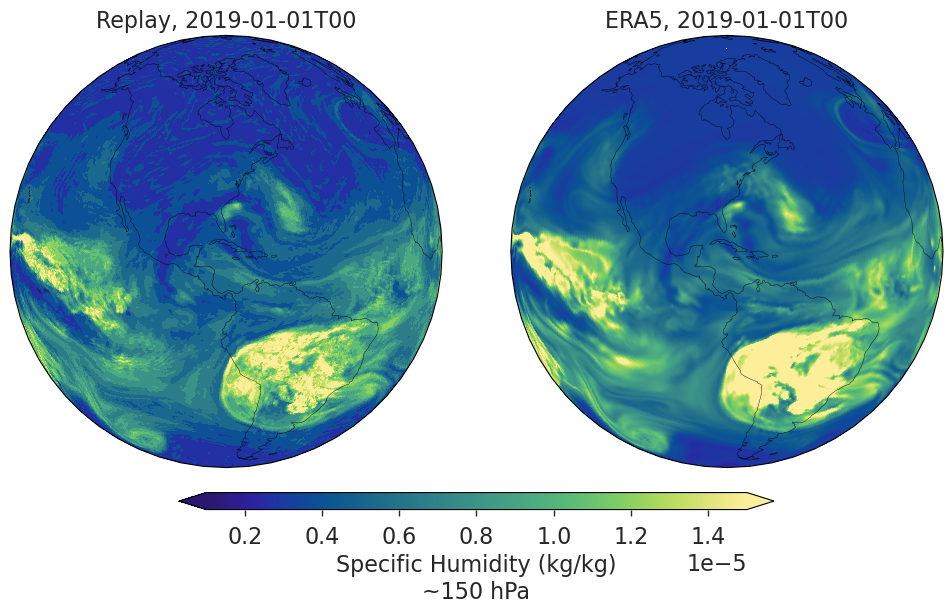

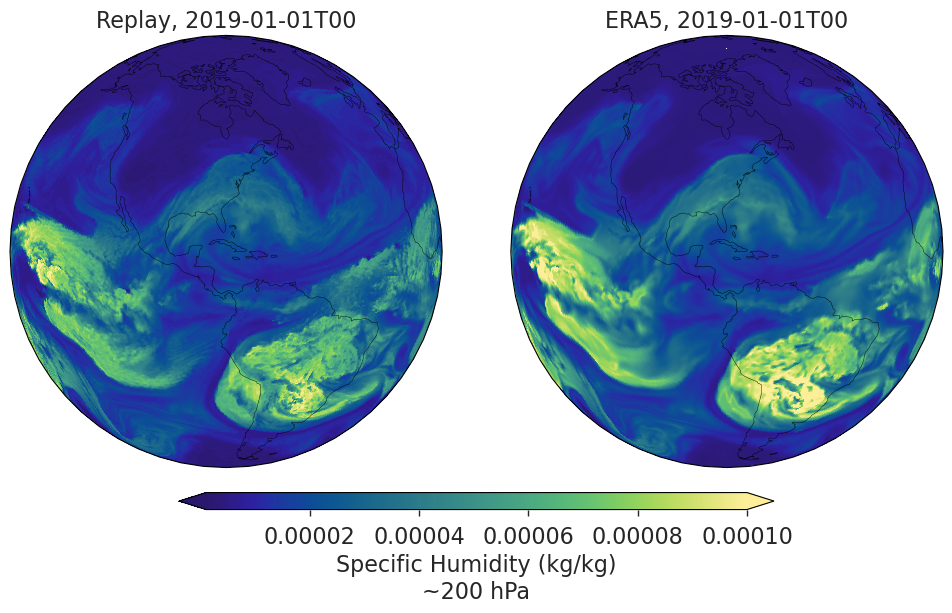

In [187]:
for level in [50, 100, 150, 200]:
    fig, axs = mapper.plot(
        rds["spfh"].sel(level=level, method="nearest"),
        era["specific_humidity"].sel(level=level),
        cmap="cmo.haline",
        vmin=vmin[level],
        vmax=vmax[level],
    )
    axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay"))
    fig.get_children()[-1].set_xlabel(f"Specific Humidity (kg/kg)\n~{level} hPa")
    #fig.savefig(f"{figdir}/spfh_{level}hpa.jpeg", bbox_inches="tight", dpi=300)

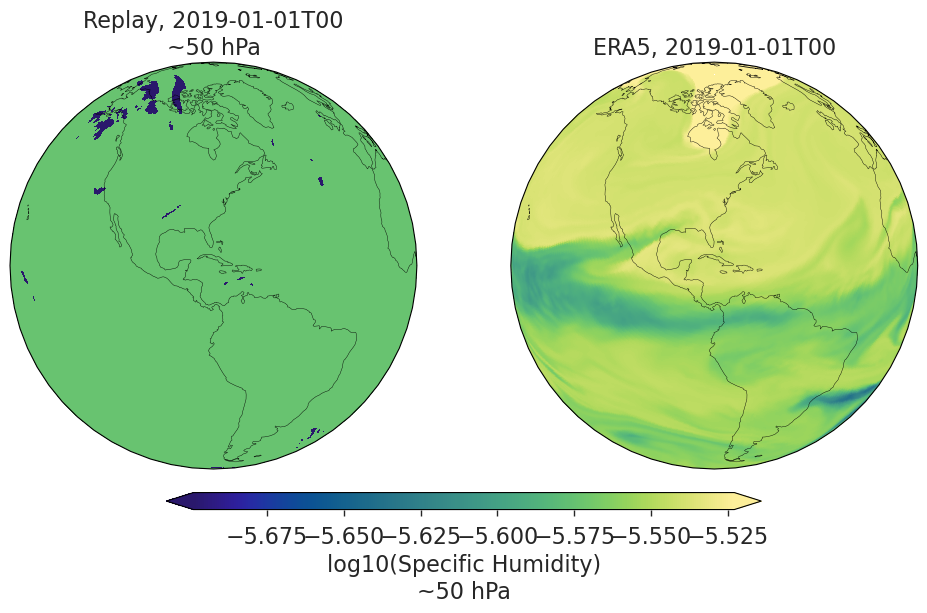

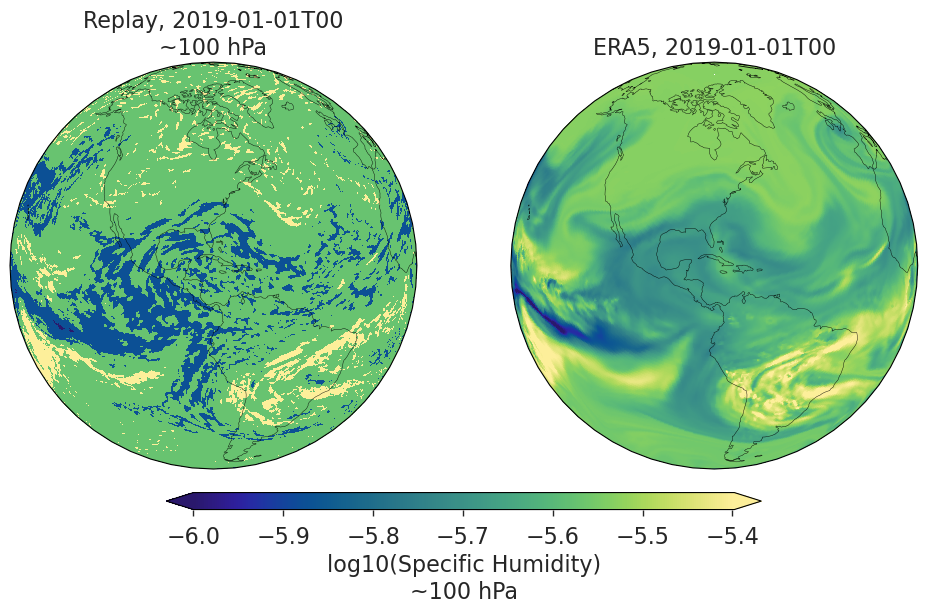

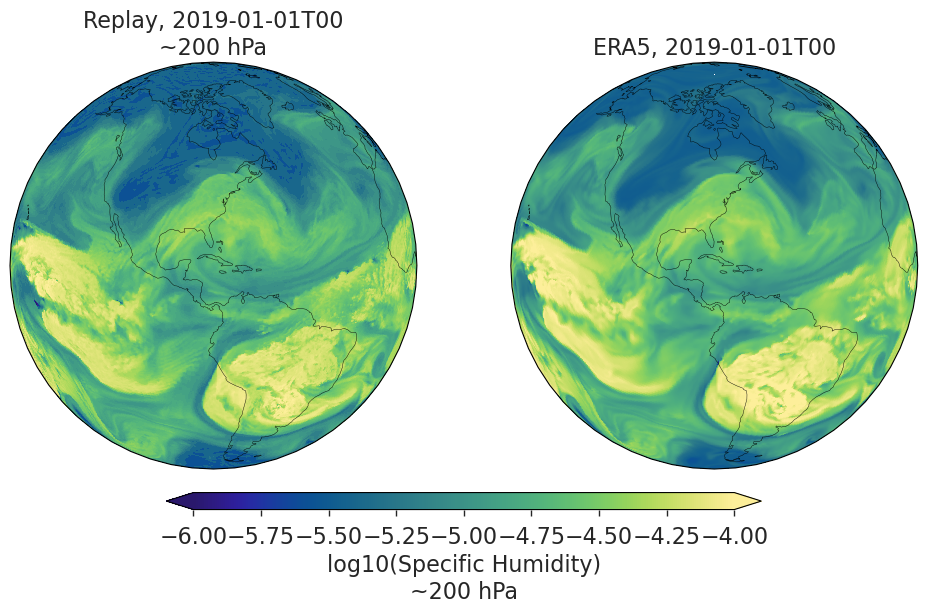

In [129]:
for level in [50, 100, 200]:
#for level in [200]:
    fig, axs = mapper.plot(
        np.log10(rds["spfh"].sel(level=level, method="nearest")),
        np.log10(era["specific_humidity"].sel(level=level)),
        cmap="cmo.haline",
        vmin=np.log10(vmin[level]),
        vmax=np.log10(vmax[level]),
    )
    axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay")+f"\n~{level} hPa")
    fig.get_children()[-1].set_xlabel(f"log10(Specific Humidity)\n~{level} hPa")


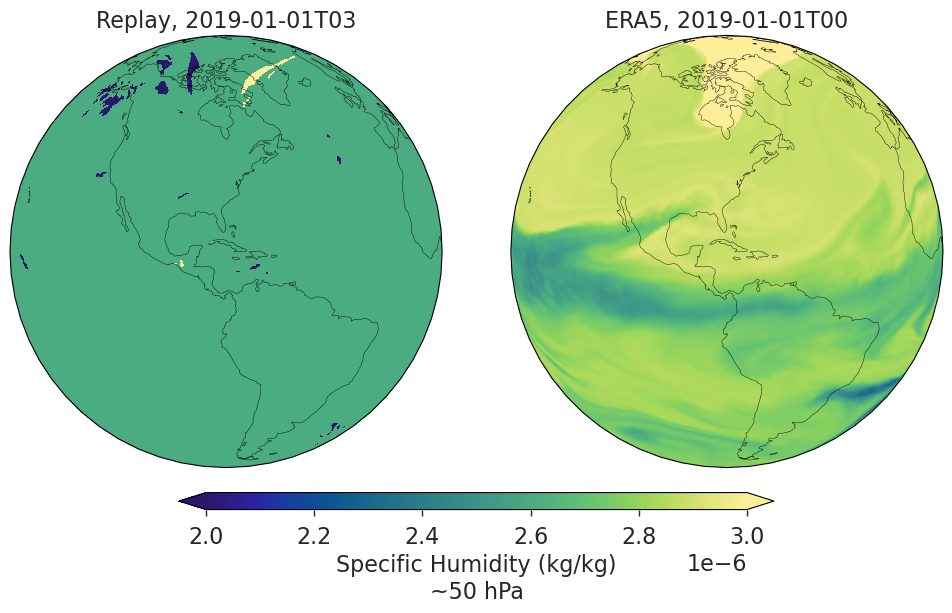

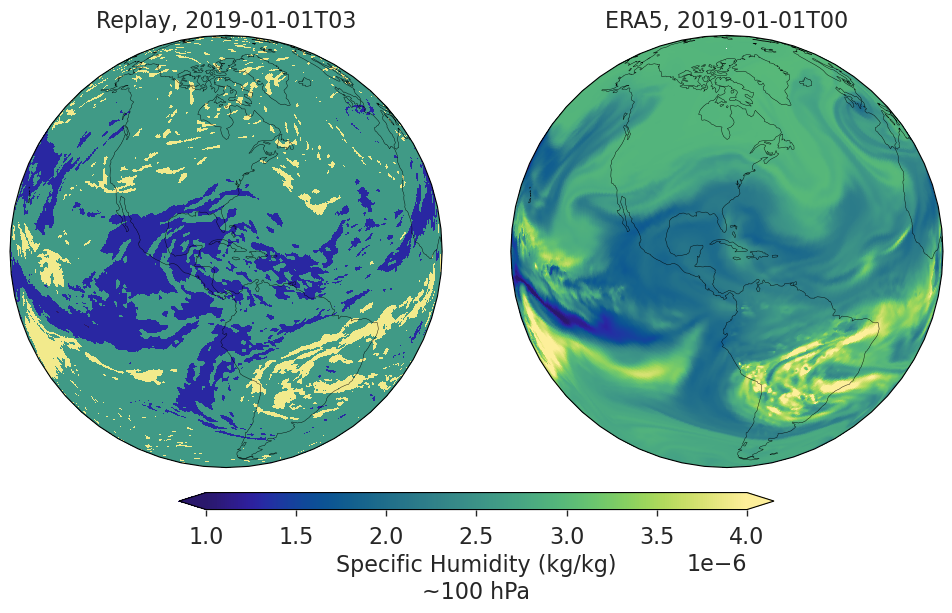

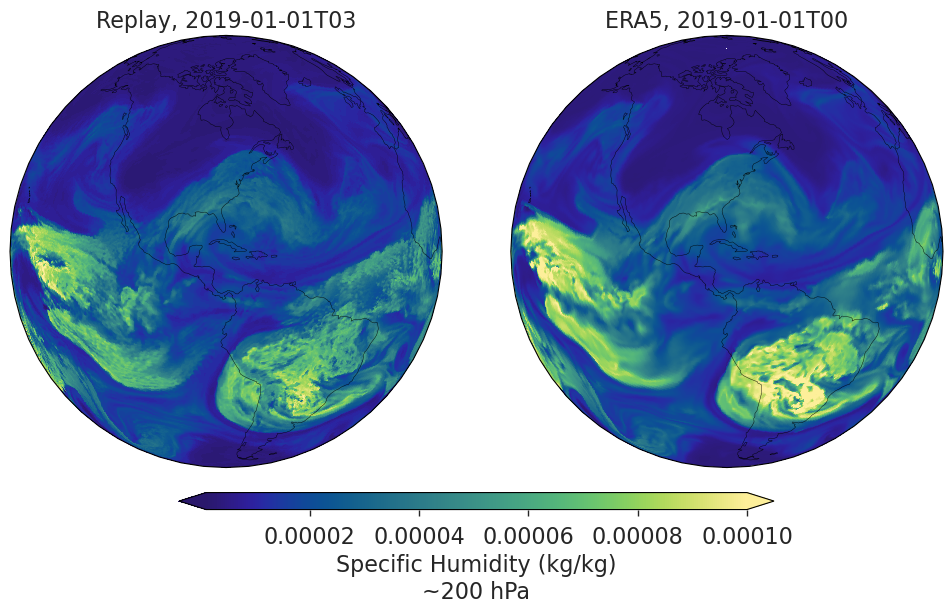

In [161]:
for level in [50, 100, 200]:
    fig, axs = mapper.plot(
        fds["spfh"].sel(level=level, method="nearest"),
        era["specific_humidity"].sel(level=level),
        cmap="cmo.haline",
        vmin=vmin[level],
        vmax=vmax[level],
    )
    axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay"))
    fig.get_children()[-1].set_xlabel(f"Specific Humidity (kg/kg)\n~{level} hPa")
    fig.savefig(f"{figdir}/forecast_spfh_{level}hpa.jpeg", bbox_inches="tight", dpi=300)

## When does humidity look bad, exactly?

In [193]:
%%time
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token":"anon"},
).rename({
    "pfull": "level",
    "grid_xt": "longitude",
    "grid_yt": "latitude",
})

rds = rds[["tmp", "spfh"]]
rds = rds.sel(
    time=date,
).sel(
    level=[154, 165, 175, 185, 195],
    method="nearest"
)
rds = rds.load()

CPU times: user 37 s, sys: 4.34 s, total: 41.3 s
Wall time: 42.6 s


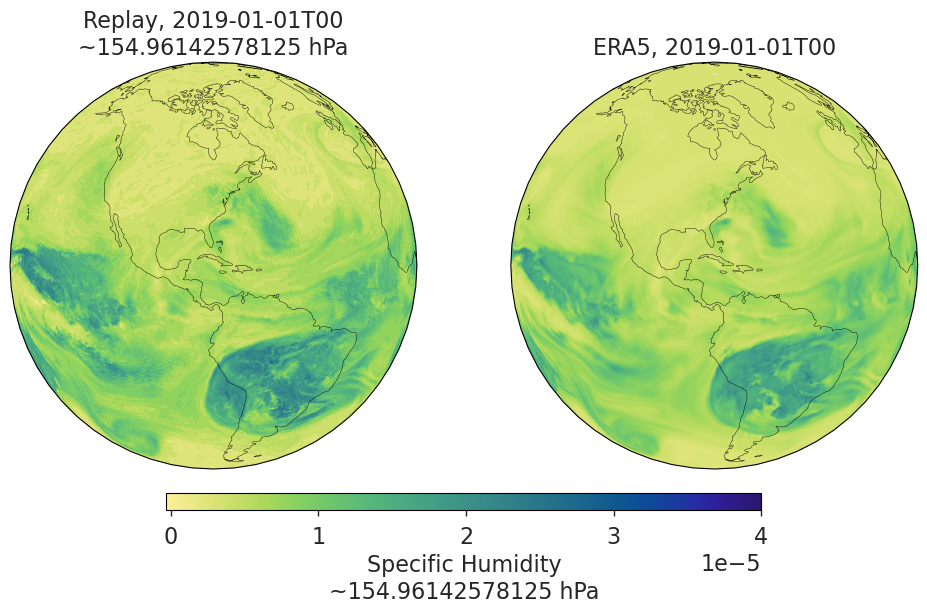

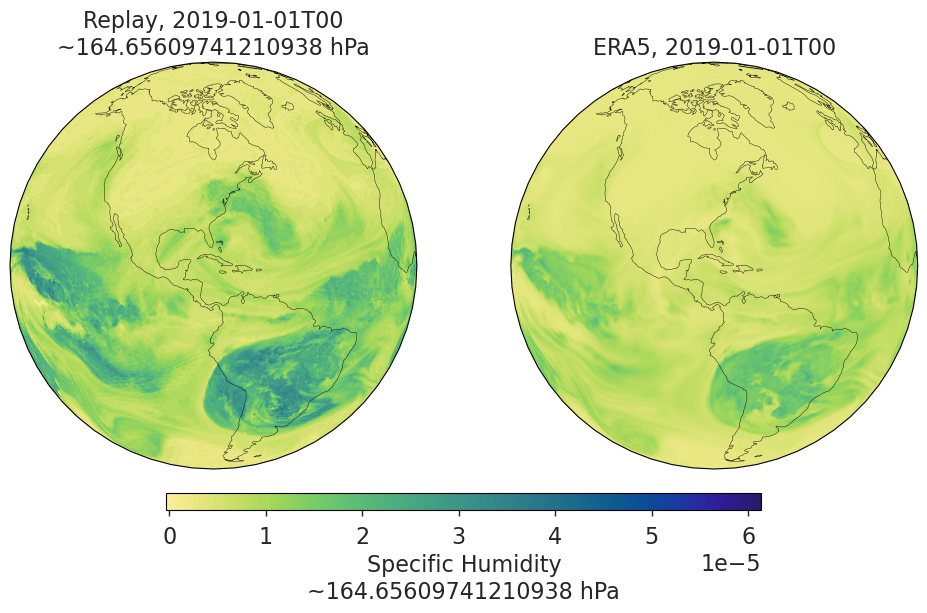

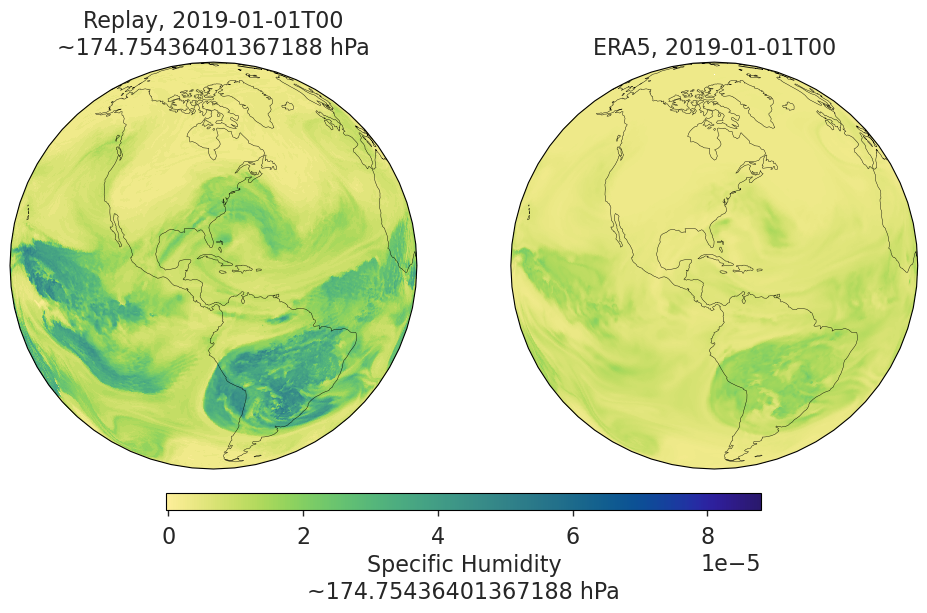

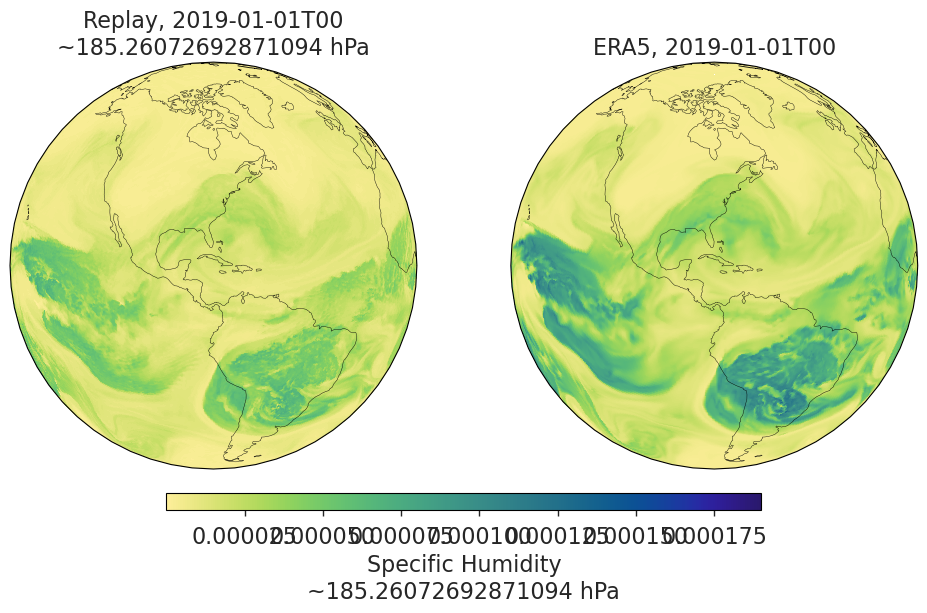

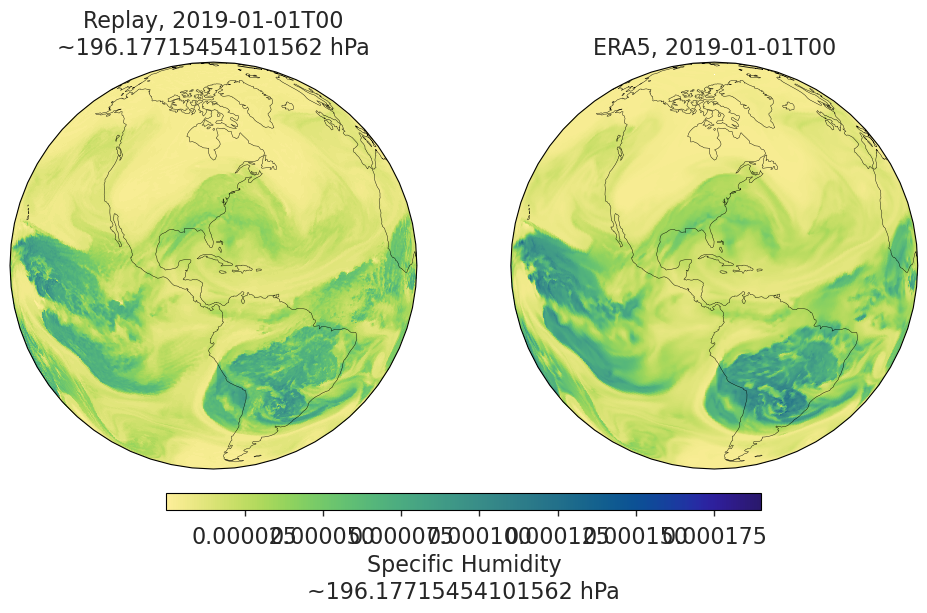

In [195]:
for level in rds.level.values:
    fig, axs = mapper.plot(
        rds["spfh"].sel(level=level, method="nearest"),
        era["specific_humidity"].sel(level=level,method="nearest"),
        cmap="cmo.haline_r",
    )
    axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay")+f"\n~{level} hPa")
    fig.get_children()[-1].set_xlabel(f"Specific Humidity\n~{level} hPa")

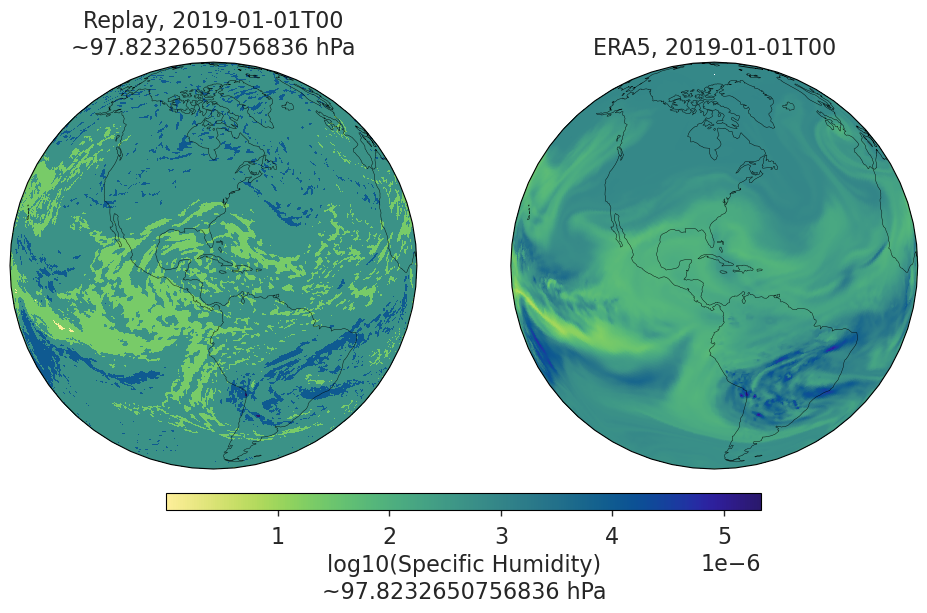

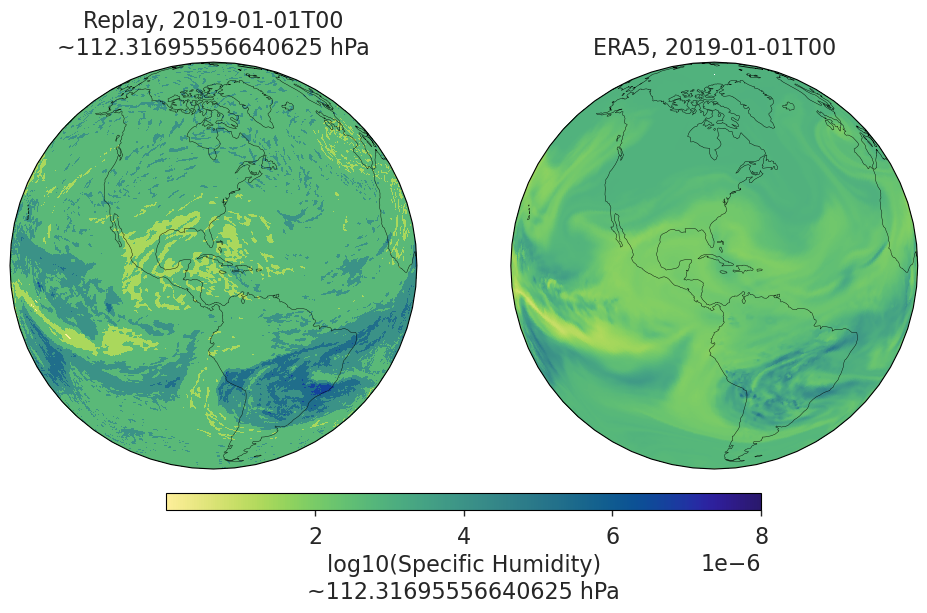

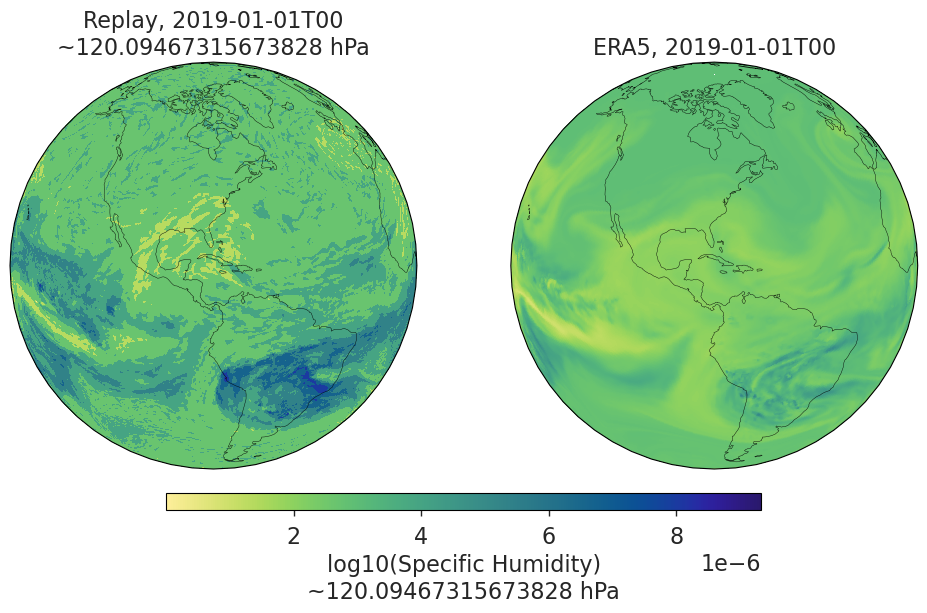

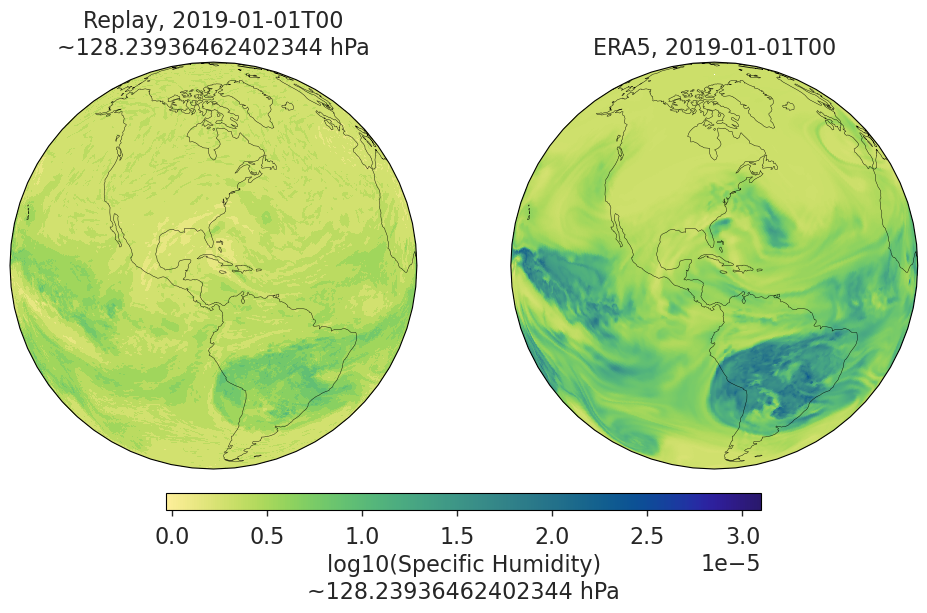

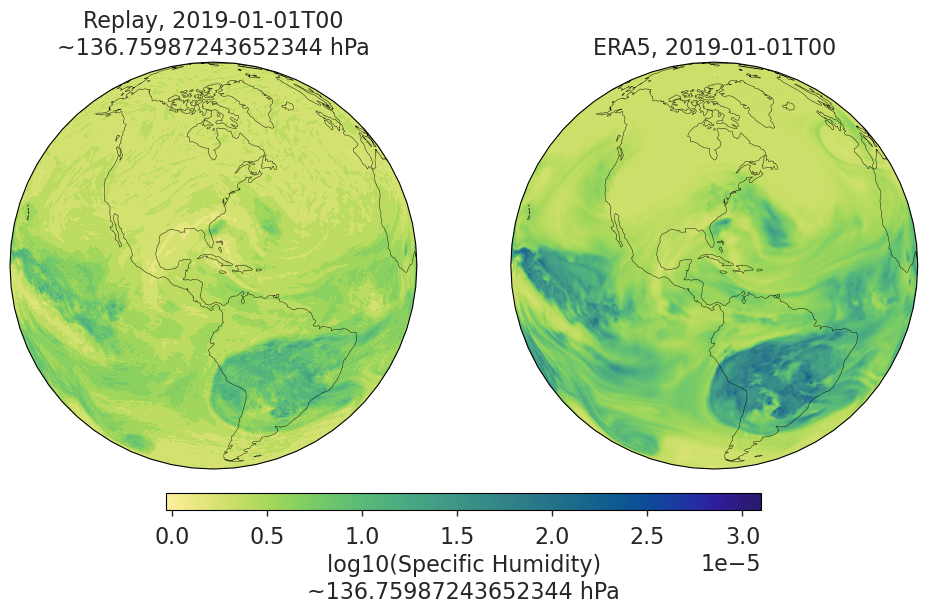

In [192]:
for level in rds.level.values:
    fig, axs = mapper.plot(
        rds["spfh"].sel(level=level, method="nearest"),
        era["specific_humidity"].sel(level=level,method="nearest"),
        cmap="cmo.haline_r",
    )
    axs[0].set(title=axs[0].get_title().replace("GraphUFS", "Replay")+f"\n~{level} hPa")
    fig.get_children()[-1].set_xlabel(f"log10(Specific Humidity)\n~{level} hPa")